## 2.1 Import Python Libraries

In [1]:
import boto3, cv2, time
import matplotlib.pyplot as plt
import numpy as np

from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import IdentitySerializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2.2 Check if Endpoint creation is successful and create the predictor

In [2]:
sm_client = boto3.client(service_name="sagemaker")

# Restore the endpoint name stored in the 2_DeployEndpoint.ipynb notebook
ENDPOINT_NAME = 'yolov8-optimized-images-serverless-endpoint' 
print(f'Endpoint Name: {ENDPOINT_NAME}')

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Name: yolov8-optimized-images-serverless-endpoint
Endpoint Status = InService


In [8]:
predictor = PyTorchPredictor(
    endpoint_name=ENDPOINT_NAME,
    serializer=IdentitySerializer(content_type='image/jpeg'),
    deserializer=JSONDeserializer()
)

## 2.3 Run Inference and Generate output results

In [22]:
orig_image = cv2.imread('./data/d3f34243-a7166713.jpg')
# Encode image as JPEG
_, encoded_img = cv2.imencode('.jpg', orig_image)
payload = encoded_img.tobytes()

In [23]:
infer_start_time = time.time()

result = predictor.predict(payload)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

Inference Time = 1.6955 seconds


In [24]:
result

{'message': 'Image uploaded successfully to S3',
 's3_path': 'results/result_2024-05-23_23-59-36.jpg'}

In [29]:
# Set up the S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and file name
bucket_name = 'zomato-project-bucket'
file_name = result['s3_path']

# Step 1: Get the image from S3
fileObj = s3.get_object(Bucket=bucket_name, Key=file_name)
file_content = fileObj['Body'].read()

# Step 2: Load the image with OpenCV
file_bytes = np.asarray(bytearray(file_content), dtype=np.uint8)
result_img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

# Step 3: Convert to RGB
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

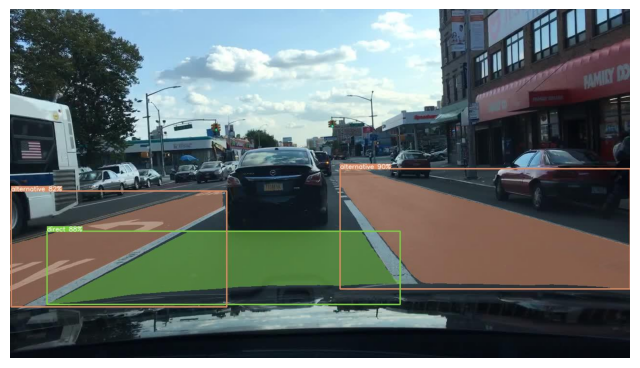

In [30]:
# Display the image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [14]:
orig_image = cv2.imread('./data/db6d38a1-4fae2f3d.jpg')
# Encode image as JPEG
_, encoded_img = cv2.imencode('.jpg', orig_image)
payload = encoded_img.tobytes()

In [15]:
infer_start_time = time.time()

result = predictor.predict(payload)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

Inference Time = 1.6793 seconds


In [16]:
result

{'message': 'Image uploaded successfully to S3',
 's3_path': 'results/result_2024-05-23_23-58-19.jpg'}

In [17]:
# Set up the S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and file name
bucket_name = 'zomato-project-bucket'
file_name = result['s3_path']

# Step 1: Get the image from S3
fileObj = s3.get_object(Bucket=bucket_name, Key=file_name)
file_content = fileObj['Body'].read()

# Step 2: Load the image with OpenCV
file_bytes = np.asarray(bytearray(file_content), dtype=np.uint8)
result_img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

# Step 3: Convert to RGB
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

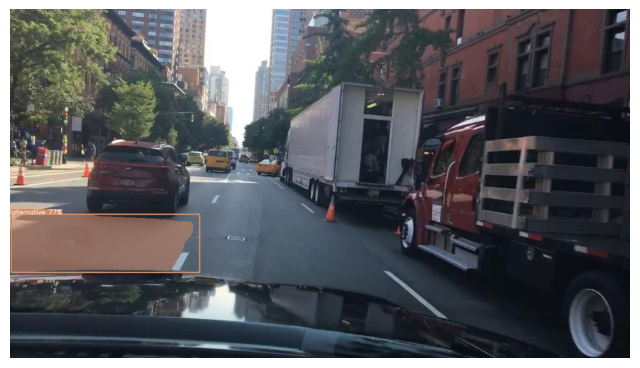

In [18]:
# Display the image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 2.4 Cleanup by removing Endpoint, Endpoint Config and Model

In [7]:
response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
print(response)
endpoint_config_name = response['EndpointConfigName']

# Delete Endpoint
sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

# Delete Endpoint Configuration
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Delete Model
for prod_var in response['ProductionVariants']:
    model_name = prod_var['ModelName']
    sm_client.delete_model(ModelName=model_name)   

{'EndpointConfigName': 'yolov8-optimized-images-serverless-endpoint', 'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:141178960309:endpoint-config/yolov8-optimized-images-serverless-endpoint', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'ModelName': 'pytorch-inference-2024-05-23-23-45-14-151', 'InitialVariantWeight': 1.0, 'ServerlessConfig': {'MemorySizeInMB': 3072, 'MaxConcurrency': 1}, 'VolumeSizeInGB': 5}], 'CreationTime': datetime.datetime(2024, 5, 23, 23, 45, 14, 956000, tzinfo=tzlocal()), 'EnableNetworkIsolation': False, 'ResponseMetadata': {'RequestId': '77ac8c3d-6f5f-4abb-a77b-813bba8a4d4e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '77ac8c3d-6f5f-4abb-a77b-813bba8a4d4e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '470', 'date': 'Thu, 23 May 2024 23:52:25 GMT'}, 'RetryAttempts': 0}}
